In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import folium
from folium.plugins import MarkerCluster
import seaborn

In [5]:
# Seperate Amenities into 7 Category

food = ['cafe', 'fast_food', 'bbq', 'restaurant', 'pub', 'bar', 'food_court', 'ice_cream', 'bistro', 'juice_bar', 
        'disused:restaurant', 'water_point', 'biergarten']

facility = ['drinking_water','shelter', 'bench', 'atm', 'luggage_locker', 'lobby', 'lounge', 'vending_machine', 
            'post_box', 'telephone', 'waste_basket', 'recycling', 'fountain', 'waste_disposal', 'social_facility', 
            'clock', 'toilets', 'shower','family_centre', 'playground', 'smoking_area', 'trash', 'leisure', 
            'letter_box','Observation Platform']

service = ['bureau_de_change','marketplace', 'storage', 'money_transfer', 'shop|clothes','community_centre', 
           'post_office', 'bank', 'photo_booth', 'construction', 'post_depot', 'conference_centre', 'fire_station', 
           'police', 'compressed_air', 'townhall', 'scrapyard', 'courthouse', 'events_venue', 'ATLAS_clean_room', 
           'workshop', 'safety', 'animal_shelter', 'internet_cafe', 'social_centre', 'vacuum_cleaner', 'studio', 
           'ranger_station', 'storage_rental', 'sanitary_dump_station', 'housing co-op', 'loading_dock', 'monastery', 
           'gym', 'payment_terminal', 'atm;bank', 'waste_transfer_station', 'office|financial']

education = ['childcare', 'school', 'university', 'library','public_bookcase', 'college', 'kindergarten',
             'music_school','language_school', 'prep_school', 'cram_school', 'science', 'driving_school',
            'training', 'research_institute']

medical = ['pharmacy', 'dentist', 'doctors', 'clinic', 'veterinary', 'nursery', 'hospital', 'meditation_centre',
          'healthcare', 'first_aid', 'chiropractor', 'Pharmacy']

entertament = ['place_of_worship', 'public_building', 'cinema', 'theatre', 'dojo', 'arts_centre', 'nightclub', 
               'stripclub','gambling', 'spa', 'watering_place', 'park', 'casino', 'hunting_stand']

transportation = ['car_sharing', 'parking_entrance', 'fuel', 'ferry_terminal', 'car_rental','seaplane terminal', 
                  'charging_station', 'taxi', 'EVSE','car_rep', 'motorcycle_rental', 'bus_station','boat_rental', 
                  'motorcycle_rental', 'bus_station', 'boat_rental''parking_entrance', 'bicycle_parking', 'parking',
                  'bicycle_rental', 'car_wash', 'bicycle_repair_station','parking_space', 'trolley_bay', 
                  'motorcycle_parking','boat_rental', 'motorcycle_rental']
seaborn.set()

def give_city_name(data):
    name = 'Not In Vancouver'
    lat = data['lat']
    lon = data['lon']
    if (49.1986<= lat <= 49.3126) & (-123.2295 <= lon <= -123.0224):
        return 'Vancouver'
    elif (49.002899 <= lat <= 49.217971) & (-122.916052 <= lon <= -122.680699):
        return "Surrey"
    elif (49.209878 <= lat <= 49.294660) & (-123.025116 <= lon <= -122.922523):
        return "Burnaby"
    elif (49.220044 <= lat <= 49.351143) & (-122.878751 <= lon <= -122.625494):
        return "Coquitlam"
    elif (49.116603 <= lat <= 49.203093) & (-123.192189 <= lon <= -123.045668):
        return "Richmond"
    elif (49.296845 <= lat <= 49.360719) & (-123.113541 <= lon <= -123.001443):
        return "North Vancouver"
    else:
        return name

def set_categories(x):
    if x.amenity in food:
        return 'food'
    elif x.amenity in facility:
        return 'facility'
    elif x.amenity in service:
        return 'service'
    elif x.amenity in education:
        return 'education'
    elif x.amenity in medical:
        return 'medical'
    elif x.amenity in entertament:
        return 'entertament'
    elif x.amenity in transportation:
        return 'transportation'
    else:
        return 'other'

def extrace_each_city(data, l):
    for city in l:
        name = 'png/'+ city + '.png'
        title = city
        temp = data[data['city'] == city]
        temp = temp.rename({'city': 'count'}, axis='columns')
        temp = temp.groupby(['category']).count()
        ax = temp.plot(kind='bar', title=city, ylabel='Count', xlabel='Categories', figsize=(10, 10))
        ax.figure.savefig(name)  

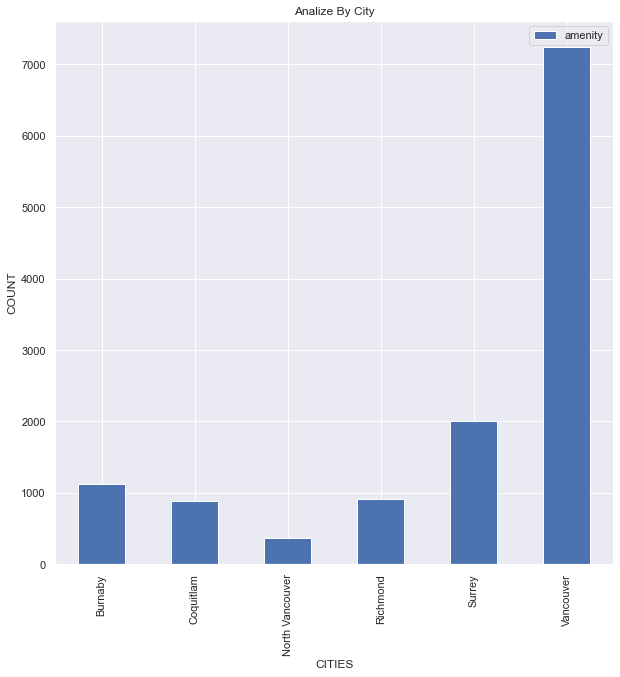

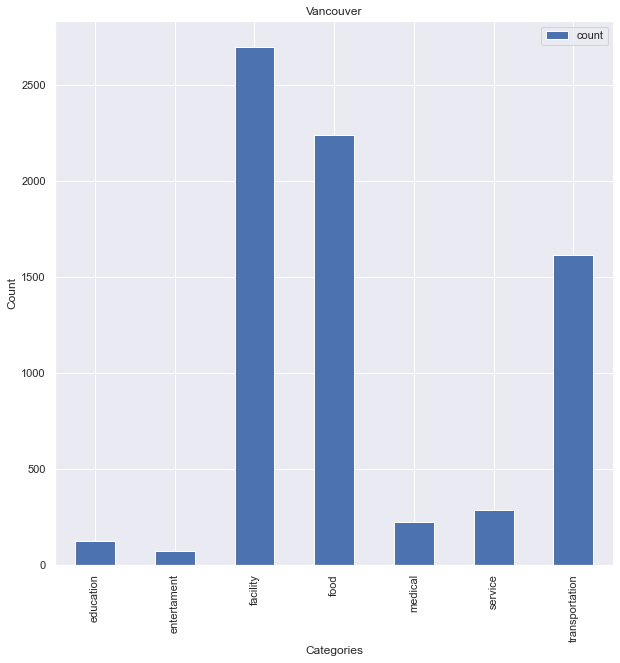

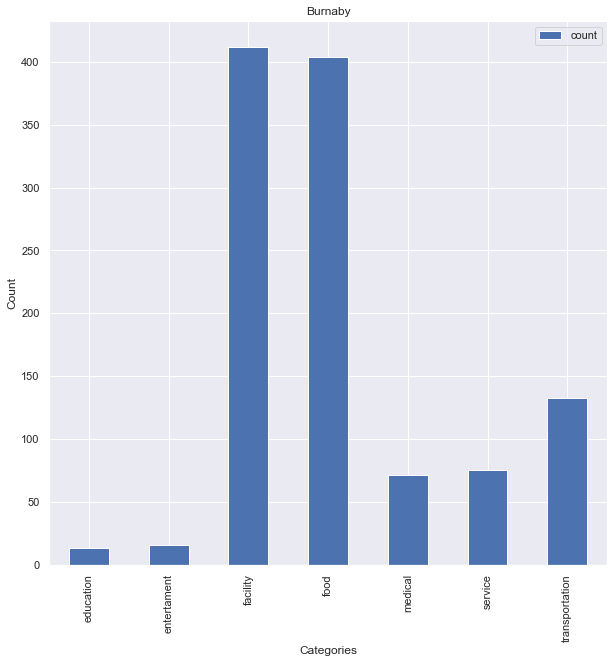

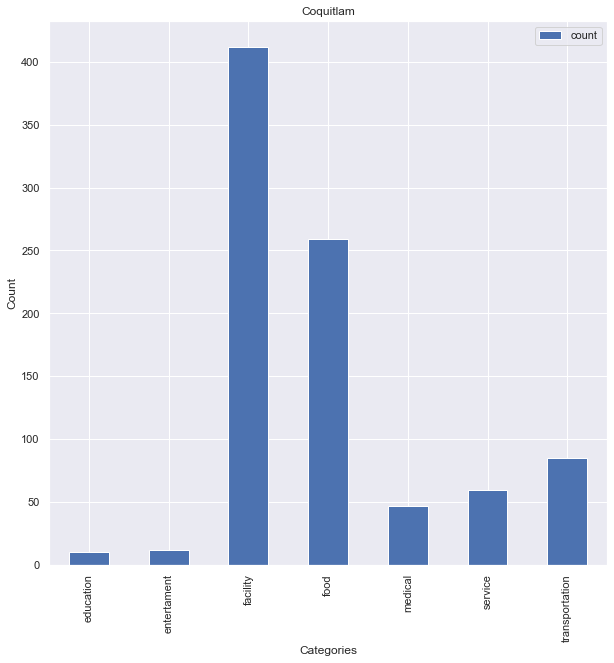

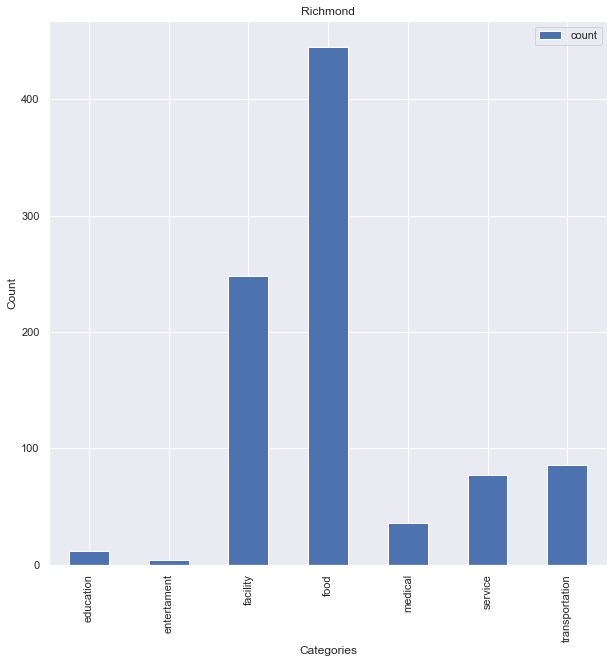

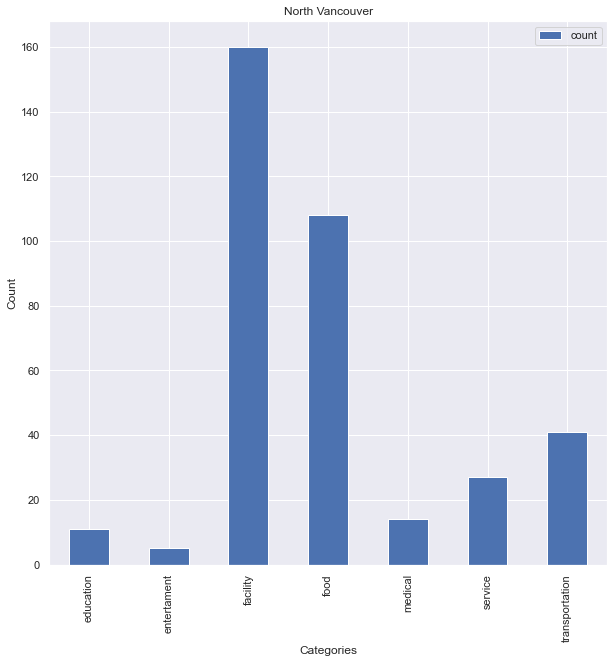

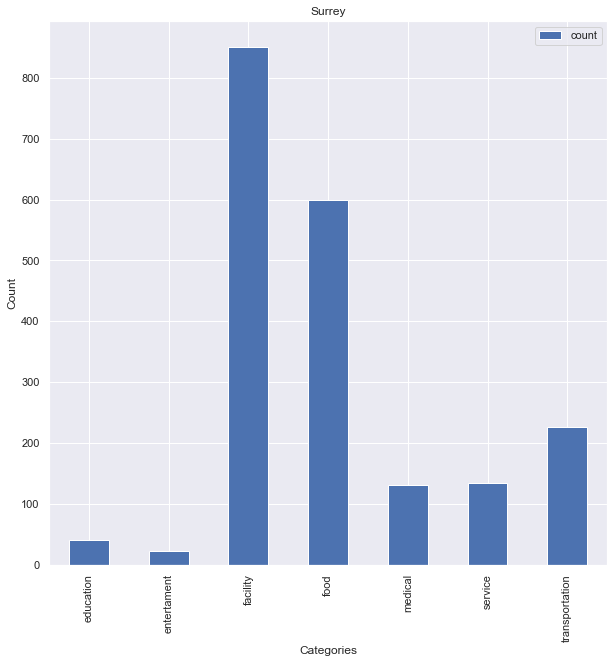

In [6]:
def main():
    # Read Original Data
    data = pd.read_json('amenities-vancouver.json.gz', lines = True, encoding="utf-8")
    
    # Give Each Row a Category
    data['category'] = data.apply(set_categories, axis=1)
    
    # Give Each Row a City
    data['city'] = data.apply(give_city_name, axis=1)
    
    # Drop These Outside Points
    data = data[data['city'] != 'Not In Vancouver']
    
    # Drop Duplicate Locations with Same Coordinate
    data = data.drop_duplicates(subset=['lat', 'lon'], keep='last')
    
    # Make Deep Copy To Protect Original Data
    processed = copy.deepcopy(data)
    # Drop Columns which are not usable in this part
    processed = processed.drop(['lat', 'lon', 'timestamp', 'tags', 'name'], axis=1)
    
    # Analize City first, So GroupBy City
    group_city = processed.drop(['category'], axis=1)
    group_city = group_city.groupby(['city']).count()
    
    # Draw Bar Chart of the Number of Amenity in Each City
    ax = group_city.plot(kind='bar', title='Analize By City', ylabel='COUNT',
             xlabel='CITIES', figsize=(10, 10))
    ax.figure.savefig('png/city_amenities.png')      
    
    # Analize Category, So GroupBy Category (in function)
    catogories = processed.drop(['amenity'], axis=1)
    region = ['Vancouver', 'Burnaby', 'Coquitlam', 'Richmond', 'North Vancouver', 'Surrey']
    # Draw Bar Chart of the Number of Each Category in Specific City
    cities = extrace_each_city(catogories, region)

    # Draw Map to See Facility Density of Whole Vancouver Region
    Van_region = [49.282730, -123.120735]
    m = folium.Map(Van_region, tiles='stamentoner', zoom_start=12)
    # create a mark cluster object
    marker_cluster = MarkerCluster().add_to(m)
    # add data point to the mark cluster
    for index, row in data.iterrows():
        folium.Marker(
            location=[row.lat, row.lon],
            icon=None,
            popup=row.name,
        ).add_to(marker_cluster)

    # add marker_cluster to map
    m.add_child(marker_cluster)
    m.save("html/MarkerCluster.html")
if __name__ == '__main__':
    main()